In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import pandas as pd
import timeit
import re
import copy as cp

from preprocessing.data_norm import *
from preprocessing.make_idx import *
from preprocessing.make_team import *
from preprocessing.train import *

In [3]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cpu')
print_every = 100
print('using device:', device)

using device: cpu


In [4]:
teamName = ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Bobcats", "Charlotte Hornets",
            "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons",
            "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers",
            "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Jeresy Nets",
            "New Orleans Hornets", "New Orleans Pelicans", "New York Knicks", "Oklahoma City Thunder", "Orlando Magic",
            "Philadelphia 76ers", "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs",
            "Seattle SuperSonics", "Toronto Raptors", "Utah Jazz", "Vancouver Grizzlies", "Washington Bullets",
            "Washington Wizards"]

Abbr = ["ATL", "BOS", "BKN", "CHA", "CHO", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM",
        "MIA", "MIL", "MIN", "NJN", "NOH", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "SEA", "TOR",
        "UTA", "VAN", "WSB", "WAS"]

In [5]:
# Index of used advanced metrics
need_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20]

In [85]:
'''
Make sure not to miss the first row of the data
when using panda.read_csv
'''
# 25 years training, 4 validation, 1 testing
trainYear = 25
startYear_train = 1989
validationYear = 0
startYear_validation = startYear_train + trainYear
testYear = 6
startYear_test = startYear_validation + validationYear

# Initialization for training set
player_list_train = [0] * trainYear
winrate_list_train = [0] * trainYear
data_list_train = [0] * trainYear
team_idx_train = [0] * trainYear
data_input_train = [0] * trainYear
loader_train = {}
loader_validation = {}
loader_test = {}

# Creating training data
for index in range(trainYear):
    # Read stats
    playerstats_train = "Player_Data/AvgPlayerStats" + str(index + startYear_train) + ".csv"
    teamstats_train = "Team_data/TeamStats" + str(index + startYear_train) + ".csv"
    # Convert type
    player_list_train[index] = pd.read_csv(playerstats_train, header = None).values
    winrate_list_train[index] = pd.read_csv(teamstats_train, header = None).values
    # Discard useless columns
    data_list_train[index] = player_list_train[index][:, 4:]
    # Normalization
    data_list_train[index] = data_norm(data_list_train[index])
    # Make abbreviations
    team_idx_train[index] = make_idx(winrate_list_train[index], Abbr, teamName)
    # Put players in same team together
    data_input_train[index] = make_team(player_list_train[index], data_list_train[index], team_idx_train[index],
                                        str(index + startYear_train), device, dtype, need_idx)
    # Put data into dictionary
    loader_train = dict(loader_train, **data_input_train[index])

# Initialization for validation set
player_list_validation = [0] * validationYear
winrate_list_validation = [0] * validationYear
data_list_validation = [0] * validationYear
team_idx_validation = [0] * validationYear
data_input_validation = [0] * validationYear

# Creating validation data
for index in range(validationYear):
    # Read stats
    playerstats_validation = "Player_Data/AvgPlayerStats" + str(index + startYear_validation) + ".csv"
    teamstats_validation = "Team_Data/TeamStats" + str(index + startYear_validation) + ".csv"
    # Convert type
    player_list_validation[index] = pd.read_csv(playerstats_validation, header = None).values
    winrate_list_validation[index] = pd.read_csv(teamstats_validation, header = None).values
    # Discard useless columns
    data_list_validation[index] = player_list_validation[index][:, 4:]
    # Normalization
    data_list_validation[index] = data_norm(data_list_validation[index])
    # Make abbreviations
    team_idx_validation[index] = make_idx(winrate_list_validation[index], Abbr, teamName)
    # Put players in same team together
    data_input_validation[index] = make_team(player_list_validation[index], data_list_validation[index],
                                             team_idx_validation[index], str(index + startYear_validation), device,
                                             dtype, need_idx)
    # Put data into dictionary
    loader_validation = dict(loader_validation, **data_input_validation[index])

# Initialization for testing data
player_list_test = [0] * testYear
winrate_list_test = [0] * testYear
data_list_test = [0] * testYear
team_idx_test = [0] * testYear
data_input_test = [0] * testYear

# Creating testing data
for index in range(testYear):
    # Read stats
    playerstats_test = "Player_Data/AvgPlayerStats" + str(index + startYear_test) + ".csv"
    teamstats_test = "Team_Data/TeamStats" + str(index + startYear_test) + ".csv"
    # Convert type
    player_list_test[index] = (pd.read_csv(playerstats_test, header = None)).values
    winrate_list_test[index] = (pd.read_csv(teamstats_test, header = None)).values
    # Discard useless columns
    data_list_test[index] = player_list_test[index][:, 4:]
    # Normalization
    data_list_test[index] = data_norm(data_list_test[index])
    # Make abbreviations
    team_idx_test[index] = make_idx(winrate_list_test[index], Abbr, teamName)
    # Put players in same team together
    data_input_test[index] = make_team(player_list_test[index], data_list_test[index], team_idx_test[index],
                                       str(index + startYear_test), device, dtype, need_idx)
    

Alex Abrines,OKC,25,16,318,6.5,.490,.767,.100,0.6,7.1,3.8,4.9,1.6,1.1,7.8,13.0,0.0,0.4,0.4,.065,-2.7,0.1,-2.5,0.0
Jaylen Adams,ATL,22,4,13,7.5,.375,1.000,.000,0.0,16.4,8.0,10.3,0.0,6.5,0.0,12.6,0.0,0.0,0.0,-0.012,-4.7,0.1,-4.6,0.0
Steven Adams,OKC,25,18,616,21.0,.593,.000,.412,15.0,16.8,15.9,7.4,2.1,2.2,10.0,17.2,1.5,1.1,2.6,.203,1.3,2.7,4.0,0.9
Bam Adebayo,MIA,21,19,361,17.5,.579,.031,.660,10.8,27.6,19.1,9.5,1.5,3.3,14.9,16.9,0.6,0.6,1.2,.154,-1.7,2.5,0.7,0.2
DeVaughn Akoon-Purcell,DEN,25,5,18,2.3,.282,.500,.250,6.1,12.1,9.1,22.2,2.7,0.0,10.1,23.4,-0.1,0.0,0.0,-0.092,-5.5,-0.8,-6.3,0.0
LaMarcus Aldridge,SAS,33,20,701,17.4,.488,.028,.300,11.2,22.9,16.7,11.3,0.6,2.8,9.8,25.3,0.4,0.7,1.1,.074,-2.2,0.5,-1.8,0.0
Grayson Allen,UTA,23,14,147,4.4,.491,.636,.418,0.8,1.6,1.2,6.2,0.3,0.0,13.3,22.1,-0.2,0.0,-0.2,-0.053,-3.9,-5.5,-9.3,-0.3
Jarrett Allen,BRK,20,19,521,21.0,.622,.096,.471,11.2,21.8,16.3,8.5,1.0,4.6,10.0,17.1,1.4,0.6,2.0,.183,1.1,2.2,3.3,0.7
Al-Farouq Aminu,POR,28,20,589,10.4,.519,.5

In [7]:
# Neural network setup
model = None
optimizer = None
num_data = 32

# A 4-layer network
# Each layer affine-norm-relu 
layer1 = nn.Sequential(
    nn.Linear(num_data, 1, bias=False),
    #nn.BatchNorm1d(30),
    #nn.ReLU()
)

layer2 = nn.Sequential(
    nn.Linear(30, 60),
    nn.BatchNorm1d(60),
    nn.ReLU()
)

layer3 = nn.Sequential(
    nn.Linear(60, 30),
    nn.BatchNorm1d(30),
    nn.ReLU()
)

layer4 = nn.Sequential(
    nn.Linear(30, 1),
    #nn.BatchNorm1d(1),
    #nn.ReLU()
)

model = nn.Sequential(
    layer1,
    #layer2,
    #layer3,
    #layer4
)
# Learning rate can be changed - advised to be less than 1e-2
learning_rate = 15e-4
# Optimizer can be changed, but SGD works well. Weight_decay means to add an L2 regularization
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

his_epoch, his_tra, his_val = train(model, loader_train, loader_validation, device, optimizer, dtype, epochs=1000,
                                    print_process=False, early_stop=False)


0 tensor(0.9686, grad_fn=<DivBackward0>)
1 tensor(0.6252, grad_fn=<DivBackward0>)
2 tensor(0.4928, grad_fn=<DivBackward0>)
3 tensor(0.4128, grad_fn=<DivBackward0>)
4 tensor(0.3575, grad_fn=<DivBackward0>)
5 tensor(0.3176, grad_fn=<DivBackward0>)
6 tensor(0.2884, grad_fn=<DivBackward0>)
7 tensor(0.2667, grad_fn=<DivBackward0>)
8 tensor(0.2503, grad_fn=<DivBackward0>)
9 tensor(0.2379, grad_fn=<DivBackward0>)
10 tensor(0.2284, grad_fn=<DivBackward0>)
11 tensor(0.2210, grad_fn=<DivBackward0>)
12 tensor(0.2152, grad_fn=<DivBackward0>)
13 tensor(0.2105, grad_fn=<DivBackward0>)
14 tensor(0.2068, grad_fn=<DivBackward0>)
15 tensor(0.2037, grad_fn=<DivBackward0>)
16 tensor(0.2012, grad_fn=<DivBackward0>)
17 tensor(0.1990, grad_fn=<DivBackward0>)
18 tensor(0.1973, grad_fn=<DivBackward0>)
19 tensor(0.1957, grad_fn=<DivBackward0>)
20 tensor(0.1944, grad_fn=<DivBackward0>)
21 tensor(0.1933, grad_fn=<DivBackward0>)
22 tensor(0.1923, grad_fn=<DivBackward0>)
23 tensor(0.1914, grad_fn=<DivBackward0>)
24

193 tensor(0.1746, grad_fn=<DivBackward0>)
194 tensor(0.1746, grad_fn=<DivBackward0>)
195 tensor(0.1745, grad_fn=<DivBackward0>)
196 tensor(0.1745, grad_fn=<DivBackward0>)
197 tensor(0.1745, grad_fn=<DivBackward0>)
198 tensor(0.1745, grad_fn=<DivBackward0>)
199 tensor(0.1745, grad_fn=<DivBackward0>)
200 tensor(0.1744, grad_fn=<DivBackward0>)
201 tensor(0.1744, grad_fn=<DivBackward0>)
202 tensor(0.1744, grad_fn=<DivBackward0>)
203 tensor(0.1744, grad_fn=<DivBackward0>)
204 tensor(0.1744, grad_fn=<DivBackward0>)
205 tensor(0.1744, grad_fn=<DivBackward0>)
206 tensor(0.1743, grad_fn=<DivBackward0>)
207 tensor(0.1743, grad_fn=<DivBackward0>)
208 tensor(0.1743, grad_fn=<DivBackward0>)
209 tensor(0.1743, grad_fn=<DivBackward0>)
210 tensor(0.1743, grad_fn=<DivBackward0>)
211 tensor(0.1743, grad_fn=<DivBackward0>)
212 tensor(0.1742, grad_fn=<DivBackward0>)
213 tensor(0.1742, grad_fn=<DivBackward0>)
214 tensor(0.1742, grad_fn=<DivBackward0>)
215 tensor(0.1742, grad_fn=<DivBackward0>)
216 tensor(

383 tensor(0.1726, grad_fn=<DivBackward0>)
384 tensor(0.1726, grad_fn=<DivBackward0>)
385 tensor(0.1726, grad_fn=<DivBackward0>)
386 tensor(0.1726, grad_fn=<DivBackward0>)
387 tensor(0.1726, grad_fn=<DivBackward0>)
388 tensor(0.1726, grad_fn=<DivBackward0>)
389 tensor(0.1726, grad_fn=<DivBackward0>)
390 tensor(0.1725, grad_fn=<DivBackward0>)
391 tensor(0.1725, grad_fn=<DivBackward0>)
392 tensor(0.1725, grad_fn=<DivBackward0>)
393 tensor(0.1725, grad_fn=<DivBackward0>)
394 tensor(0.1725, grad_fn=<DivBackward0>)
395 tensor(0.1725, grad_fn=<DivBackward0>)
396 tensor(0.1725, grad_fn=<DivBackward0>)
397 tensor(0.1725, grad_fn=<DivBackward0>)
398 tensor(0.1725, grad_fn=<DivBackward0>)
399 tensor(0.1725, grad_fn=<DivBackward0>)
400 tensor(0.1725, grad_fn=<DivBackward0>)
401 tensor(0.1725, grad_fn=<DivBackward0>)
402 tensor(0.1725, grad_fn=<DivBackward0>)
403 tensor(0.1725, grad_fn=<DivBackward0>)
404 tensor(0.1725, grad_fn=<DivBackward0>)
405 tensor(0.1725, grad_fn=<DivBackward0>)
406 tensor(

573 tensor(0.1718, grad_fn=<DivBackward0>)
574 tensor(0.1718, grad_fn=<DivBackward0>)
575 tensor(0.1718, grad_fn=<DivBackward0>)
576 tensor(0.1718, grad_fn=<DivBackward0>)
577 tensor(0.1718, grad_fn=<DivBackward0>)
578 tensor(0.1718, grad_fn=<DivBackward0>)
579 tensor(0.1718, grad_fn=<DivBackward0>)
580 tensor(0.1718, grad_fn=<DivBackward0>)
581 tensor(0.1718, grad_fn=<DivBackward0>)
582 tensor(0.1718, grad_fn=<DivBackward0>)
583 tensor(0.1718, grad_fn=<DivBackward0>)
584 tensor(0.1718, grad_fn=<DivBackward0>)
585 tensor(0.1718, grad_fn=<DivBackward0>)
586 tensor(0.1718, grad_fn=<DivBackward0>)
587 tensor(0.1718, grad_fn=<DivBackward0>)
588 tensor(0.1718, grad_fn=<DivBackward0>)
589 tensor(0.1718, grad_fn=<DivBackward0>)
590 tensor(0.1718, grad_fn=<DivBackward0>)
591 tensor(0.1718, grad_fn=<DivBackward0>)
592 tensor(0.1718, grad_fn=<DivBackward0>)
593 tensor(0.1718, grad_fn=<DivBackward0>)
594 tensor(0.1717, grad_fn=<DivBackward0>)
595 tensor(0.1717, grad_fn=<DivBackward0>)
596 tensor(

763 tensor(0.1714, grad_fn=<DivBackward0>)
764 tensor(0.1714, grad_fn=<DivBackward0>)
765 tensor(0.1714, grad_fn=<DivBackward0>)
766 tensor(0.1714, grad_fn=<DivBackward0>)
767 tensor(0.1714, grad_fn=<DivBackward0>)
768 tensor(0.1714, grad_fn=<DivBackward0>)
769 tensor(0.1714, grad_fn=<DivBackward0>)
770 tensor(0.1714, grad_fn=<DivBackward0>)
771 tensor(0.1714, grad_fn=<DivBackward0>)
772 tensor(0.1714, grad_fn=<DivBackward0>)
773 tensor(0.1714, grad_fn=<DivBackward0>)
774 tensor(0.1714, grad_fn=<DivBackward0>)
775 tensor(0.1714, grad_fn=<DivBackward0>)
776 tensor(0.1714, grad_fn=<DivBackward0>)
777 tensor(0.1714, grad_fn=<DivBackward0>)
778 tensor(0.1714, grad_fn=<DivBackward0>)
779 tensor(0.1714, grad_fn=<DivBackward0>)
780 tensor(0.1714, grad_fn=<DivBackward0>)
781 tensor(0.1714, grad_fn=<DivBackward0>)
782 tensor(0.1714, grad_fn=<DivBackward0>)
783 tensor(0.1714, grad_fn=<DivBackward0>)
784 tensor(0.1714, grad_fn=<DivBackward0>)
785 tensor(0.1714, grad_fn=<DivBackward0>)
786 tensor(

953 tensor(0.1712, grad_fn=<DivBackward0>)
954 tensor(0.1712, grad_fn=<DivBackward0>)
955 tensor(0.1712, grad_fn=<DivBackward0>)
956 tensor(0.1712, grad_fn=<DivBackward0>)
957 tensor(0.1712, grad_fn=<DivBackward0>)
958 tensor(0.1712, grad_fn=<DivBackward0>)
959 tensor(0.1712, grad_fn=<DivBackward0>)
960 tensor(0.1712, grad_fn=<DivBackward0>)
961 tensor(0.1712, grad_fn=<DivBackward0>)
962 tensor(0.1712, grad_fn=<DivBackward0>)
963 tensor(0.1712, grad_fn=<DivBackward0>)
964 tensor(0.1712, grad_fn=<DivBackward0>)
965 tensor(0.1712, grad_fn=<DivBackward0>)
966 tensor(0.1712, grad_fn=<DivBackward0>)
967 tensor(0.1712, grad_fn=<DivBackward0>)
968 tensor(0.1712, grad_fn=<DivBackward0>)
969 tensor(0.1712, grad_fn=<DivBackward0>)
970 tensor(0.1712, grad_fn=<DivBackward0>)
971 tensor(0.1712, grad_fn=<DivBackward0>)
972 tensor(0.1712, grad_fn=<DivBackward0>)
973 tensor(0.1712, grad_fn=<DivBackward0>)
974 tensor(0.1712, grad_fn=<DivBackward0>)
975 tensor(0.1712, grad_fn=<DivBackward0>)
976 tensor(

In [8]:
from matplotlib import pyplot as plt

# Plotting losses
l1 = plt.plot(his_epoch, his_tra, color='blue', linewidth=1.0, label='line')
l2 = plt.plot(his_epoch, his_val, color='red', linewidth=1.0, linestyle='--', label='line')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(labels=['train_loss', 'validation_loss'], loc='best')
plt.show()


<Figure size 640x480 with 1 Axes>

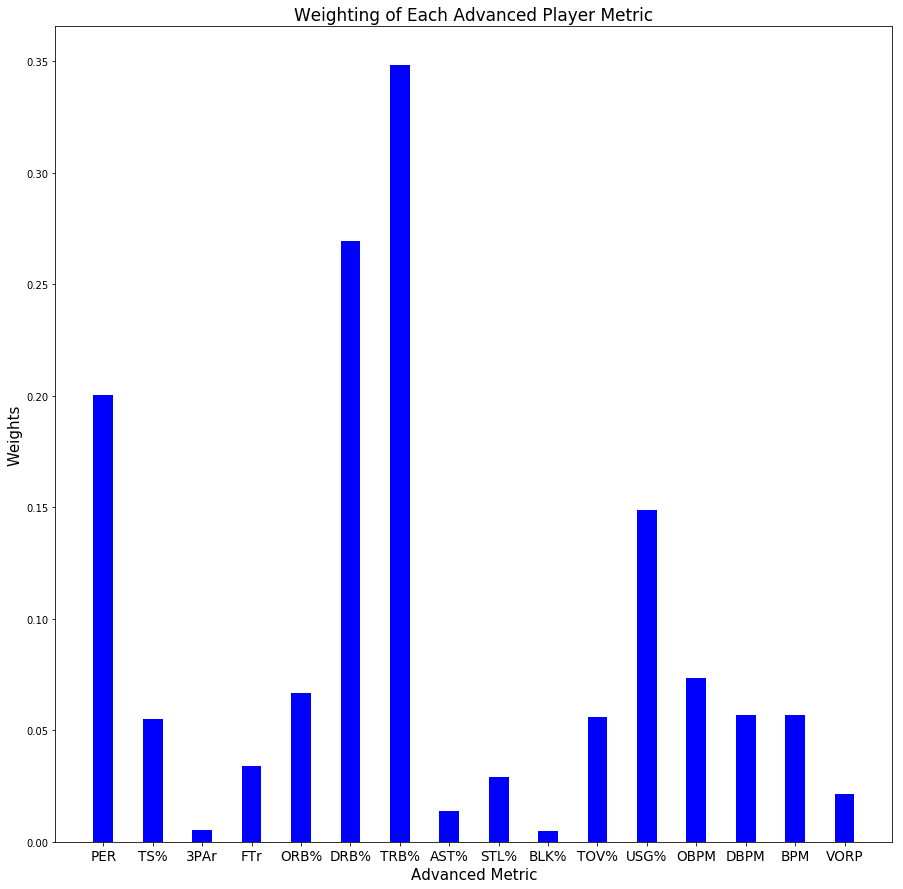

In [14]:
# Visualization of the weights
data_name = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OBPM',
             'DBPM', 'BPM', 'VORP']
weight = abs(model.state_dict()['0.0.weight'][0])
bar_width = 0.4
x_axis = np.arange(len(data_name))
y_axis_1 = tuple(weight[:16])
#y_axis_2 = tuple(weight[16:32])
poly1 = plt.bar(x_axis, y_axis_1, bar_width, color='b')
#poly2 = plt.bar(x_axis + 0.4, y_axis_2, bar_width, color='rgb')
plt.xticks(x_axis , data_name,fontsize = 13.5)
plt.title('Weighting of Each Advanced Player Metric',fontsize = 17)
plt.xlabel('Advanced Metric',fontsize = 15)
plt.ylabel('Weights',fontsize = 15)
plt.gcf().set_size_inches(15, 15)
plt.savefig('trained_model\index_code1_poly2.2.png')


C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


tensor(0.4872, grad_fn=<SelectBackward>)


C:\Users\c1yeung\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


tensor(0.4563, grad_fn=<SelectBackward>)
tensor(0.2648, grad_fn=<SelectBackward>)
tensor(0.1577, grad_fn=<SelectBackward>)
tensor(0.6011, grad_fn=<SelectBackward>)
tensor(0.5517, grad_fn=<SelectBackward>)
tensor(0.3285, grad_fn=<SelectBackward>)
tensor(0.4282, grad_fn=<SelectBackward>)
tensor(0.2292, grad_fn=<SelectBackward>)
tensor(0.6191, grad_fn=<SelectBackward>)
tensor(0.4979, grad_fn=<SelectBackward>)
tensor(0.4527, grad_fn=<SelectBackward>)
tensor(0.4728, grad_fn=<SelectBackward>)
tensor(0.2971, grad_fn=<SelectBackward>)
tensor(0.6464, grad_fn=<SelectBackward>)
tensor(0.6520, grad_fn=<SelectBackward>)
tensor(0.6016, grad_fn=<SelectBackward>)
tensor(0.3767, grad_fn=<SelectBackward>)
tensor(0.3097, grad_fn=<SelectBackward>)
tensor(0.7549, grad_fn=<SelectBackward>)
tensor(0.6870, grad_fn=<SelectBackward>)
tensor(0.5599, grad_fn=<SelectBackward>)
tensor(0.2921, grad_fn=<SelectBackward>)
tensor(0.3146, grad_fn=<SelectBackward>)
tensor(0.6970, grad_fn=<SelectBackward>)
tensor(0.6687, g

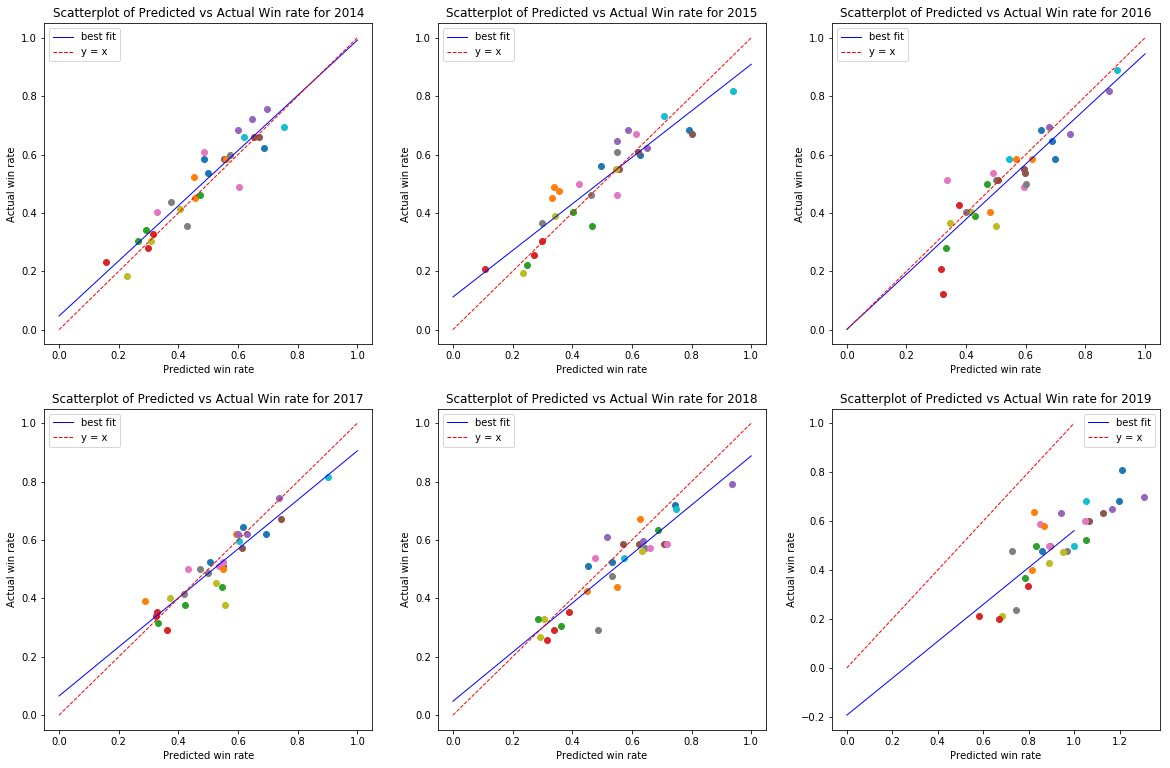

In [80]:
# Display testing set results

x = []
y = []
loss = 0
pre_dic = [0]*6
for i in range(6):
    x = []
    y = []
    loss = 0
    pre_dic[i] = {} 
    for t, content in data_input_test[i].items():
        plt.subplot(2,3,i+1)
        PER_C = model(content[0])
        # Loss is the mean square error
        win_rate = sum(PER_C)
        plt.scatter(win_rate[0].data, content[1][0].data)
        x.append(win_rate[0].data)
        y.append(content[1][0].data)
        loss += (win_rate[0] - content[1][0].data) ** 2
        pre_dic[i][t] = win_rate[0].data
        print(win_rate[0])
    print(loss)
    z1 = np.polyfit(x, y, 1)
    p1 = np.poly1d(z1)
    x = np.linspace(0, 1, 100)
    y = z1[0] * x + z1[1]

    l1 = plt.plot(x, y, color='blue', linewidth=1.0, label='line')
    x = np.linspace(0, 1, 100)
    y = x
    l2 = plt.plot(x, y, color='red', linewidth=1.0, linestyle='--', label='line')
    plt.gcf().set_size_inches(10, 10)
    plt.gcf().set_size_inches(20, 13)
    plt.ylabel("Actual win rate")
    plt.xlabel("Predicted win rate")
    plt.title("Scatterplot of Predicted vs Actual Win rate for "+str(i+2014))
    plt.legend(labels=['best fit', 'y = x'], loc='best')

plt.show()


In [75]:
# Warning - This cell will overwrite the previous model
torch.save(model, 'trained_model\index_code1_poly2.9.fit')
torch.save(model.state_dict(), 'trained_model\index_code1_poly2.9.pkl')

model.state_dict()


OrderedDict([('0.0.weight',
              tensor([[ 0.2003,  0.0551, -0.0051,  0.0342, -0.0666, -0.2696,  0.3483,  0.0136,
                       -0.0292, -0.0049, -0.0560, -0.1490, -0.0734, -0.0566,  0.0571,  0.0215,
                       -0.0426,  0.0000,  0.0439, -0.0175, -0.0171, -0.0268,  0.0819, -0.0156,
                        0.0461, -0.0312,  0.0118,  0.0794,  0.0708,  0.1348,  0.1387, -0.1283]]))])

In [21]:
print(pre_dic)
print(len(pre_dic))

[{'TOR2014': tensor(0.4872), 'NYK2014': tensor(0.4563), 'BOS2014': tensor(0.2648), 'PHI2014': tensor(0.1577), 'IND2014': tensor(0.6011), 'CHI2014': tensor(0.5517), 'CLE2014': tensor(0.3285), 'DET2014': tensor(0.4282), 'MIL2014': tensor(0.2292), 'MIA2014': tensor(0.6191), 'WAS2014': tensor(0.4979), 'CHA2014': tensor(0.4527), 'ATL2014': tensor(0.4728), 'ORL2014': tensor(0.2971), 'OKC2014': tensor(0.6464), 'POR2014': tensor(0.6520), 'MIN2014': tensor(0.6016), 'DEN2014': tensor(0.3767), 'UTA2014': tensor(0.3097), 'LAC2014': tensor(0.7549), 'GSW2014': tensor(0.6870), 'PHO2014': tensor(0.5599), 'SAC2014': tensor(0.2921), 'LAL2014': tensor(0.3146), 'SAS2014': tensor(0.6970), 'HOU2014': tensor(0.6687), 'MEM2014': tensor(0.4843), 'DAL2014': tensor(0.5745), 'NOP2014': tensor(0.4066)}, {'TOR2015': tensor(0.6272), 'BOS2015': tensor(0.3381), 'PHI2015': tensor(0.2484), 'NYK2015': tensor(0.1091), 'CLE2015': tensor(0.5500), 'CHI2015': tensor(0.6206), 'MIL2015': tensor(0.4217), 'IND2015': tensor(0.4613

In [40]:
'''
Warning: number of games in GameResults2018 is different from that in bettingOdds2018,
the reason maybe some preseason games are not included.
'''

# Implement the strategy to the testing year, combining with the betting odds
betting_data = [0] * testYear
prediction = []
ML_stg = dict()
money_visit_dic = {0:[],0:[],0:[],0:[],0:[]}
money_home_dic = {0:[],0:[],0:[],0:[],0:[]}
result_pre_dic = {0:[],0:[],0:[],0:[],0:[]}

for index in range(testYear):
    betting_file = "Betting_Data/bettingOdds" + str(startYear_test + index) + ".csv"
    betting_data[index] = (pd.read_csv(betting_file)).values
    prefix = 'Prediction_Result'
    version = startYear_test+index
    fileName = 'prefi'
    # Strategy set based on the Machine learning result
    ML_stg[str(startYear_test + index)] = []
   
    money_visit_dic[str(index+startYear_test)] = []
    money_home_dic[str(index+startYear_test)] = []
    result_pre_dic[str(index+startYear_test)] = []
    with open('Prediction_Result.txt', 'w') as part:
        for i in range(len(betting_data[index])):    
            # Get abbr for each team : 'teamname' + 'year'
            try:
                home_position = teamName.index((betting_data[index][i][0]))
                home_Abbr = Abbr[home_position] + str(startYear_test+index)
                visiting_position = teamName.index((betting_data[index][i][1]))
                visiting_Abbr = Abbr[visiting_position] + str(startYear_test+index)
            except:
                pass
            
            # Get the general winrate for each team, using the model we trained
            if (home_Abbr in pre_dic[index] and visiting_Abbr in pre_dic[index]):       
                home_winrate = pre_dic[index][home_Abbr]
                visiting_winrate = pre_dic[index][visiting_Abbr]
                home_odds = betting_data[index][i][2]               
                visiting_odds = betting_data[index][i][3]
                # Win rate for current game
                home_winrate_cg = (home_winrate) / (home_winrate + visiting_winrate)
                visiting_winrate_cg = (visiting_winrate) / (home_winrate + visiting_winrate)
                if home_winrate_cg > visiting_winrate_cg:
                    result_cg = 'Home'
                else:
                    result_cg = 'Visiting'
                result_pre_dic[str(index+startYear_test)].append(result_cg)
                #moneywin : expected gain when I invest $100 into a specific team
                if (home_odds > 0):
                    # Here I think there are some mistakes in former calculation       
                    
                    #host_win = host_winrate * host_odds * (-visiting_odds * 100 + 100)
                    money_home_win = home_winrate * (home_odds + 100)
                    #visiting_win = visiting_winrate * (-visiting_odds * 100 + 100)
                    money_visit_win = visiting_winrate * (100 * 100 / (-visiting_odds) + 100)
                    money_home_dic[str(index+startYear_test)].append(money_home_win)
                    money_visit_dic[str(index+startYear_test)].append(money_visit_win)
                else:
                    #host_win = host_winrate * (-host_odds * 100 + 100)
                    #visiting_win = visiting_winrate * visiting_odds * (-host_odds)
                    money_home_win = home_winrate * (100 * 100 / (-home_odds) + 100)
                    money_visit_win = visiting_winrate * (visiting_odds + 100)
                    money_home_dic[str(index+startYear_test)].append(money_home_win)
                    money_visit_dic[str(index+startYear_test)].append(money_visit_win)
                if (money_home_win >= money_visit_win):
                    decision = 'Home'
                else:
                    decision = 'Visiting'
                ML_stg[str(startYear_test + index)].append(decision)
                result = 'Match: ' + visiting_Abbr + ' @ ' + home_Abbr + ' | ' + 'Win Prob: ' + str(
                    home_winrate_cg) + ' vs ' + str(visiting_winrate_cg) + ' | ' + 'Odds: ' + str(home_odds) + ' to ' + str(
                    visiting_odds) + ' | ' + 'Recommendation: ' + decision + '\n'
                part.write(result)
    

#print(type(host_winrate))

# Let's see based on the strategy, how much money will we gain if we buy $100 for each game
# A.K.A strategy evaluation
money_visit_dic.pop(0)
money_home_dic.pop(0)
gain_ML = 0
count = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "GameData/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile)).values

    len_com = min(len(result_data),len(ML_stg[str(year)]))

    for i in range(len_com):  
        count += 1
        if ML_stg[str(year)][i] == result_data[i][2]:


            if ML_stg[str(year)][i] == 'Visiting':
  
                gain_ML += money_visit_dic[str(year)][i]
            else:
                gain_ML += money_home_dic[str(year)][i]
print(gain_ML)
print(count)


# Consider random strategy

gain_rand = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "GameData/GameResults" + str(year) + ".csv"    
    result_data = (pd.read_csv(resultfile)).values
    len_com = min(len(money_home_dic[str(year)]),len(result_data))
    for i in range(len_com):
        decision = np.random.randint(0,2)
      
        if decision == 0 and result_data[i][2] == 'Visiting':
            gain_rand += money_visit_dic[str(year)][i]
        if decision == 1 and result_data[i][2] == 'Home':
            gain_rand += money_home_dic[str(year)][i]
print(gain_rand)

# Consider greedy strategy

# 1. Always stick to the negative one (Odds)
gain_gdy_neg = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "GameData/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile)).values
    betting_file = "Betting_Data/bettingOdds" + str(year) + ".csv"
    betting_data = (pd.read_csv(betting_file)).values
    len_com = min(len(money_visit_dic[str(year)]),len(result_data))

    for i in range(len_com):
        if betting_data[i][3] < 0:
            decision = 0
        else:
            decision = 1
        if decision == 0 and result_data[i][2] == 'Visiting':
            gain_gdy_neg += money_visit_dic[str(year)][i]
        if decision == 1 and result_data[i][2] == 'Home':
            gain_gdy_neg += money_home_dic[str(year)][i]
print(gain_gdy_neg)

# 2. Always stick to the positive one (Odds)
gain_gdy_pos = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "GameData/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile)).values
    betting_file = "Betting_Data/bettingOdds" + str(year) + ".csv"
    betting_data = (pd.read_csv(betting_file)).values
    len_com = min(len(money_visit_dic[str(year)]),len(result_data))

    for i in range(len_com):
        if betting_data[i][3] > 0:
            decision = 0
        else:
            decision = 1
        if decision == 0 and result_data[i][2] == 'Visiting':
            gain_gdy_pos += money_visit_dic[str(year)][i]
        if decision == 1 and result_data[i][2] == 'Home':
            gain_gdy_pos += money_home_dic[str(year)][i]
print(gain_gdy_pos)


# Consider the Case when we just buy the team we think we win the game
# regradless of the odds

gain_win = 0
for year in range(startYear_test, testYear + startYear_test):
    resultfile = "GameData/GameResults" + str(year) + ".csv"
    result_data = (pd.read_csv(resultfile, header=None)).values
    pre_result = result_pre_dic[str(year)]
    len_com = min(len(money_visit_dic[str(year)]),len(result_data))

    for i in range(len_com):
        if pre_result == 'Visiting':
            decision = 0
        else:
            decision = 1
        if decision == 0 and result_data[i][2] == 'Visiting':
            gain_win += money_visit_dic[str(year)][i]
        if decision == 1 and result_data[i][2] == 'Home':
            gain_win += money_home_dic[str(year)][i]
print(gain_win)

tensor(481521.6562)
6465
tensor(381413.4688)
tensor(381461.9375)
tensor(375088.4688)
tensor(359120.0938)


In [37]:
# Strategy evaluation

print(pre_dic)

[{'TOR2014': tensor(0.4872), 'NYK2014': tensor(0.4563), 'BOS2014': tensor(0.2648), 'PHI2014': tensor(0.1577), 'IND2014': tensor(0.6011), 'CHI2014': tensor(0.5517), 'CLE2014': tensor(0.3285), 'DET2014': tensor(0.4282), 'MIL2014': tensor(0.2292), 'MIA2014': tensor(0.6191), 'WAS2014': tensor(0.4979), 'CHA2014': tensor(0.4527), 'ATL2014': tensor(0.4728), 'ORL2014': tensor(0.2971), 'OKC2014': tensor(0.6464), 'POR2014': tensor(0.6520), 'MIN2014': tensor(0.6016), 'DEN2014': tensor(0.3767), 'UTA2014': tensor(0.3097), 'LAC2014': tensor(0.7549), 'GSW2014': tensor(0.6870), 'PHO2014': tensor(0.5599), 'SAC2014': tensor(0.2921), 'LAL2014': tensor(0.3146), 'SAS2014': tensor(0.6970), 'HOU2014': tensor(0.6687), 'MEM2014': tensor(0.4843), 'DAL2014': tensor(0.5745), 'NOP2014': tensor(0.4066)}, {'TOR2015': tensor(0.6272), 'BOS2015': tensor(0.3381), 'PHI2015': tensor(0.2484), 'NYK2015': tensor(0.1091), 'CLE2015': tensor(0.5500), 'CHI2015': tensor(0.6206), 'MIL2015': tensor(0.4217), 'IND2015': tensor(0.4613

[646500.      481521.65625 375088.46875 381461.9375  359120.09375
 381413.46875]


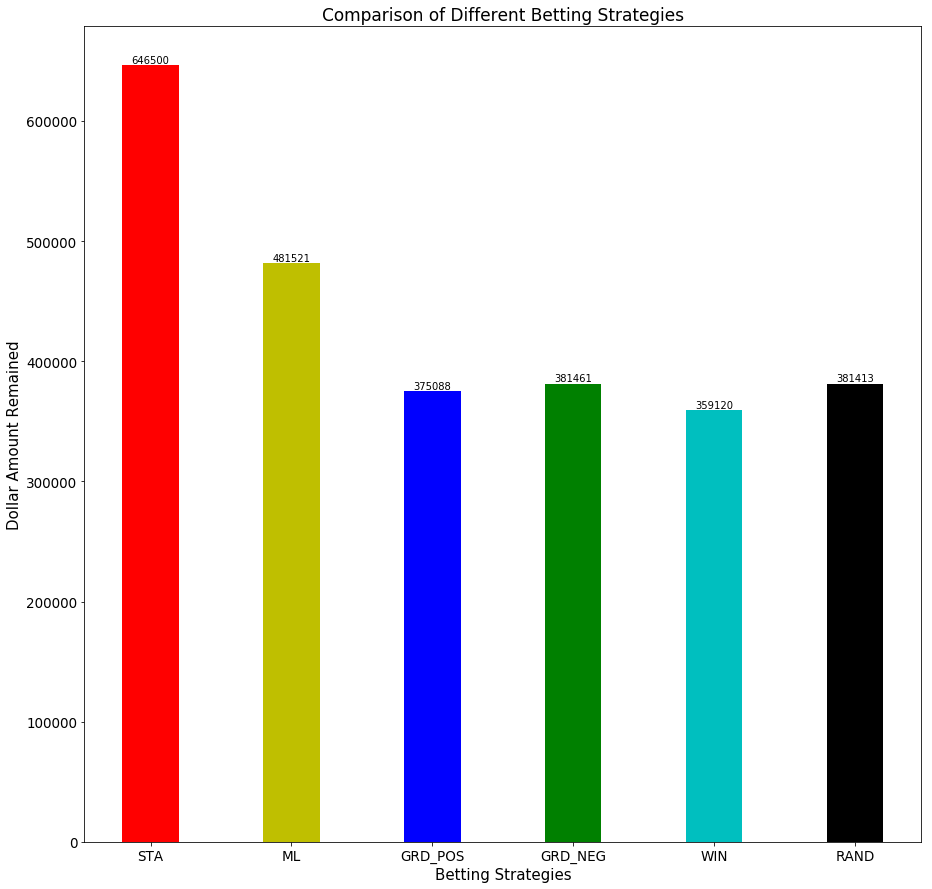

In [67]:
gain = [count * 100,gain_ML, gain_gdy_pos, gain_gdy_neg, gain_win, gain_rand]
method_name = ['STA','ML','GRD_POS','GRD_NEG','WIN','RAND']
bar_width = 0.4
x_axis = np.arange(len(gain))
y_axis = tuple(gain)
fig,ax = plt.subplots()
poly = ax.bar(x_axis, y_axis, bar_width, color='rybgck')
plt.title('Comparison of Different Betting Strategies', fontsize=17)
plt.xlabel('Betting Strategies', fontsize=15)
plt.ylabel('Dollar Amount Remained', fontsize=15)
plt.xticks(x_axis, method_name, fontsize=13.5)
for rect in poly:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
plt.yticks(fontsize=13.5)
plt.gcf().set_size_inches(15, 15)
plt.savefig('Strategy_comp.png')

a = np.array(gain)
print(a)